# Tutorial

In this tutorial we create a (simplified) synthetic galaxy image from scratch, along with its associated segmentation map, and then run the statmorph code on it.

### Setting up

We import some Python packages first. If you are missing any of these, see the the Installation section of the README.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from astropy.modeling import models
import photutils
import time
import statmorph
%matplotlib inline

For convenience, we define a simple function to apply a logarithmic scaling to our images:

In [2]:
def log_scaling(image):
    retval = np.zeros_like(image)
    m, M = np.min(image), np.max(image)
    locs = image > m
    retval[locs] = np.log10(image[locs]-m) / np.log10(M-m)
    return retval

### Creating a model galaxy image

We assume that the image size is 450x450 pixels, and that the "true" light distribution is described by a 2D Sersic profile:

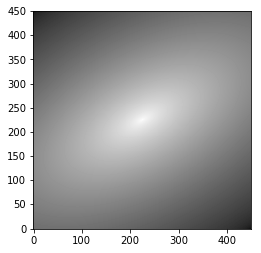

In [3]:
ny, nx = 450, 450
y, x = np.mgrid[0:ny, 0:nx]
sersic_model = models.Sersic2D(amplitude=1, r_eff=30, n=1.5, x_0=nx/2, y_0=ny/2,
                               ellip=0.5, theta=0.5)
image = sersic_model(x, y)
plt.imshow(log_scaling(image), origin='lower', cmap='gray')

### Convolving with a PSF

In practice, every astronomical image is the convolution of a "true" image with a point spread function (PSF), which depends on the optics of the telescope, atmospheric conditions, etc. Here we assume that the PSF is a simple 2D Gaussian distribution:

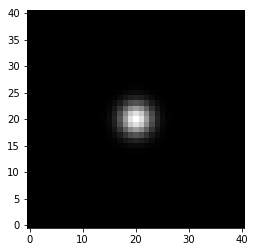

In [4]:
size = 20  # on each side from the center
sigma_psf = 2.0
y, x = np.mgrid[-size:size+1, -size:size+1]
psf = np.exp(-(x**2 + y**2)/(2.0*sigma_psf**2))
psf /= np.sum(psf)
plt.imshow(psf, origin='lower', cmap='gray')

Now we convolve the image with the PSF.

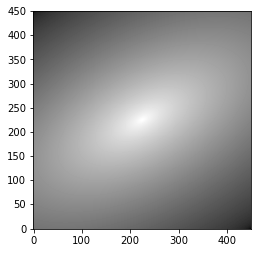

In [5]:
image = ndi.convolve(image, psf)
plt.imshow(log_scaling(image), origin='lower', cmap='gray')

### Adding noise

Here we add homogeneous Gaussian noise, assuming that the signal-to-noise ratio (S/N) at the effective radius is 25. Typically, the overall S/N of the source will be worse than this, since most of the galaxy pixels (as defined by the segmentation map) are found outside of the effective radius.

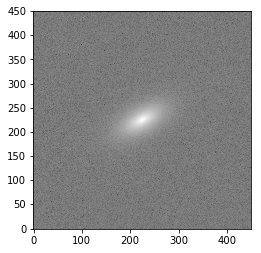

In [6]:
np.random.seed(0)
snp = 25.0
image += (1.0 / snp) * np.random.standard_normal(size=(ny, nx))
plt.imshow(log_scaling(image), origin='lower', cmap='gray')

### Creating a segmentation map

Besides the image itself, the only other *required* argument is the segmentation map, which labels the pixels belonging to different sources. It is usually generated by specialized tools such as SExtractor. Here we create it using photutils:

In [7]:
threshold = photutils.detect_threshold(image, snr=1.5)
npixels = 5  # minimum number of connected pixels
segm = photutils.detect_sources(image, threshold, npixels)

Although statmorph is designed to process a large mosaic image with potentially hundreds of sources, in this example we just focus on the main source detected in the segmentation map.

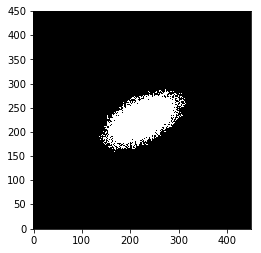

In [8]:
# Keep only the largest segment (label=0 is reserved for the background)
label = np.argmax(segm.areas[1:]) + 1
segmap = segm.data == label
plt.imshow(segmap, origin='lower', cmap='gray')

Regularize a bit the shape of the segmentation map:

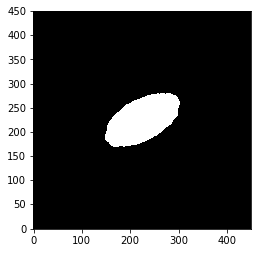

In [9]:
segmap_float = ndi.uniform_filter(np.float64(segmap), size=15)
segmap = segmap_float > 0.5
plt.imshow(segmap, origin='lower', cmap='gray')

### Measuring morphology

Now that we have all the required data, we are ready to measure the morphology of the source just created. Although not required, we are including the PSF as a keyword argument. In principle, this results in more correct Sersic profile fits, although it can also make the code run slower by a factor of 2 or so.

In [10]:
start = time.time()
source_morphs = statmorph.source_morphology(image, segmap, psf=psf)
print('Time: %g s.' % (time.time() - start))

Time: 8.65443 s.


In general, source_morphs is a list of objects, each corresponding to a labeled source in the image. However, here we only focus on the first labeled source.

In [11]:
morph = source_morphs[0]

Now we print several of the morphological properties just calculated:

In [12]:
print('ellipticity =', morph.ellipticity)
print('elongation =', morph.elongation)
print('orientation =', morph.orientation)
print('rpetro_circ =', morph.rpetro_circ)
print('rpetro_ellip =', morph.rpetro_ellip)
print('rhalf_circ =', morph.rhalf_circ)
print('rhalf_ellip =', morph.rhalf_ellip)
print('Gini =', morph.gini)
print('M20 =', morph.m20)
print('F(G, M20) =', morph.gini_m20_bulge)
print('sn_per_pixel =', morph.sn_per_pixel)
print('C =', morph.concentration)
print('A =', morph.asymmetry)
print('S =', morph.smoothness)
print('sersic_n =', morph.sersic_n)
print('sersic_rhalf =', morph.sersic_rhalf)
print('sersic_ellip =', morph.sersic_ellip)
print('sersic_theta =', morph.sersic_theta)
print('flag =', morph.flag)
print('flag_sersic =', morph.flag_sersic)

ellipticity = 0.498488658118
elongation = 1.99397285064
orientation = 0.49966022352
rpetro_circ = 50.52934158578916
rpetro_ellip = 67.58777036876265
rhalf_circ = 21.97014310473579
rhalf_ellip = 28.84614042659046
Gini = 0.537492024356
M20 = -1.93788485111
F(G, M20) = 0.153539722381
sn_per_pixel = 6.97444803111
C = 3.19205541491
A = -0.0193075522591
S = 0.0439991128383
sersic_n = 1.50847576851
sersic_rhalf = 30.1213689614
sersic_ellip = 0.500235565751
sersic_theta = 0.499531375481
flag = 0
flag_sersic = 0


Note that the fitted Sersic profile is in pretty good agreement with the "true" Sersic profile that we originally defined (n=1.5, r_eff=30, etc.). However, such agreement tends to deteriorate somewhat at higher noise levels and larger Sersic indices. Other morphological measurements that are more robust to noise, which are also calculated by statmorph, include the Gini-M20 (Lotz et al. 2004), CAS (Conselice 2003) and MID (Freeman et al. 2013) statistics, as well as the outer asymmetry (Wen et al. 2014) and shape asymmetry (Pawlik et al. 2016).

Also note that statmorph calculates two different "bad measurement" flags (where 0 means good measurement; 1 means bad):

1. ``flag`` : indicates a problem with the basic morphological measurements.

2. ``flag_sersic`` : indicates if there was a problem/warning during the Sersic profile fitting.

In general, ``flag==0`` should always be enforced, while ``flag_sersic==0`` should only be used when interested in Sersic fits (which might fail for merging galaxies and other "irregular" objects).

### Examining the fitted Sersic profile

Finally, we can reconstruct the fitted Sersic profile and examine its residual:

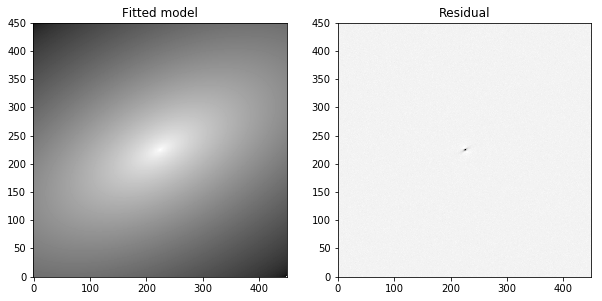

In [13]:
ny, nx = image.shape
y, x = np.mgrid[0:ny, 0:nx]
fitted_model = models.Sersic2D(
    amplitude=morph.sersic_amplitude,
    r_eff=morph.sersic_rhalf,
    n=morph.sersic_n,
    x_0=morph.sersic_xc,
    y_0=morph.sersic_yc,
    ellip=morph.sersic_ellip,
    theta=morph.sersic_theta)
image_model = fitted_model(x, y)
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax.imshow(log_scaling(image_model), origin='lower', cmap='gray')
ax.set_title('Fitted model')
ax = fig.add_subplot(122)
residual = image - image_model
ax.imshow(residual, origin='lower', cmap='gray')
ax.set_title('Residual')